<a href="https://colab.research.google.com/github/KarinaTC/GANS_bioinformatic/blob/main/Data_Augmentation_GAN_Blood_cells_cancer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation Blood cells cancer



**Data augmentation**

In recent years, deep learning has gained popularity due to its impressive results in
various vision-based artificial intelligence tasks. However, these networks require large amounts of data to perform well and avoid overfitting. Unfortunately, many application domains do not have access to such extensive datasets. Even when data is available, it is common to encounter unbalanced datasets, where there are many examples of one class but only a few samples of another.

Data augmentation is a technique used to improve model generalization and performance, as well as to overcome class imbalance. The idea behind data augmentation is to artificially increase the training dataset by adding specific properties and creating variations of existing data, making the dataset more diverse. Some common techniques include geometric transformations, color space augmentations, kernel filters, image mixing, random erasing, feature space augmentation, and GAN-based augmentation.


## Dataset
This dataset consisted of 3242 images from 89 patients suspected of Acute Lymphoblastic Leukemia(ALL). This dataset is divided into two classes benign and malignant. The former comprises hematogenous, and the latter is the ALL group with three subtypes of malignant lymphoblasts: Early Pre-B, Pre-B, and Pro-B ALL.
<br/>
See [Dataset](https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class/data)
<br/>
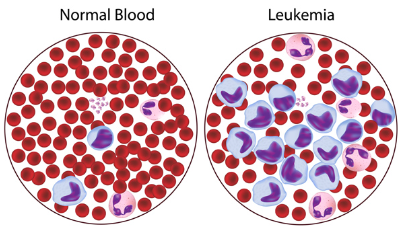
<br/>

Image taken from [Acute Lymphocytic Leukemia Case Study](https://www.weber.edu/casestudies/leukemia.html)

## Install libraries

In [1]:
# Install kaggle
!pip install -q kaggle

In [2]:
# Generate new folder "kaggle"
!mkdir -p ~/.kaggle

Upload the kaggle.json file, which is the API Token.
For more information on how to use the Kaggle API with Google Colab to upload and download datasets, see [Uploading and Downloading Data from Kaggle](https://platzi.com/tutoriales/1794-pandas/6926-usando-la-api-de-kaggle-con-google-colab-para-carga-y-descarga-de-datasets/)

In [3]:
# Change the path of the file to the kaggle folder
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
# Download dataset
!kaggle datasets download -d mohammadamireshraghi/blood-cell-cancer-all-4class

Dataset URL: https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 1.67G/1.68G [00:23<00:00, 137MB/s]
100% 1.68G/1.68G [00:23<00:00, 77.2MB/s]


In [6]:
# Unzip folder
!unzip -q blood-cell-cancer-all-4class.zip

In [7]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import cv2
import imageio
import glob
import zipfile
from PIL import Image
from pathlib import Path
from IPython import display
from tqdm.auto import tqdm # Loading bar

# Import pytorch libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Import torchvision packages
from torchvision import datasets
from torchvision import transforms

## 1. Get data

In [8]:
# Data augmentation one-class (Malignant lymphoblasts: Pre-B)
# Get list of images in folder
images = Path("/content/Blood cell Cancer [ALL]/[Malignant] Pre-B" ).glob("*.jpg")
image_strings = [str(p) for p in images]
print(f"Number of images in folder: {len(image_strings)}")

Number of images in folder: 955


Random image path: /content/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_123 - Copy.jpg
Size of image: 768 x 1024
Number of channels: ('R', 'G', 'B')


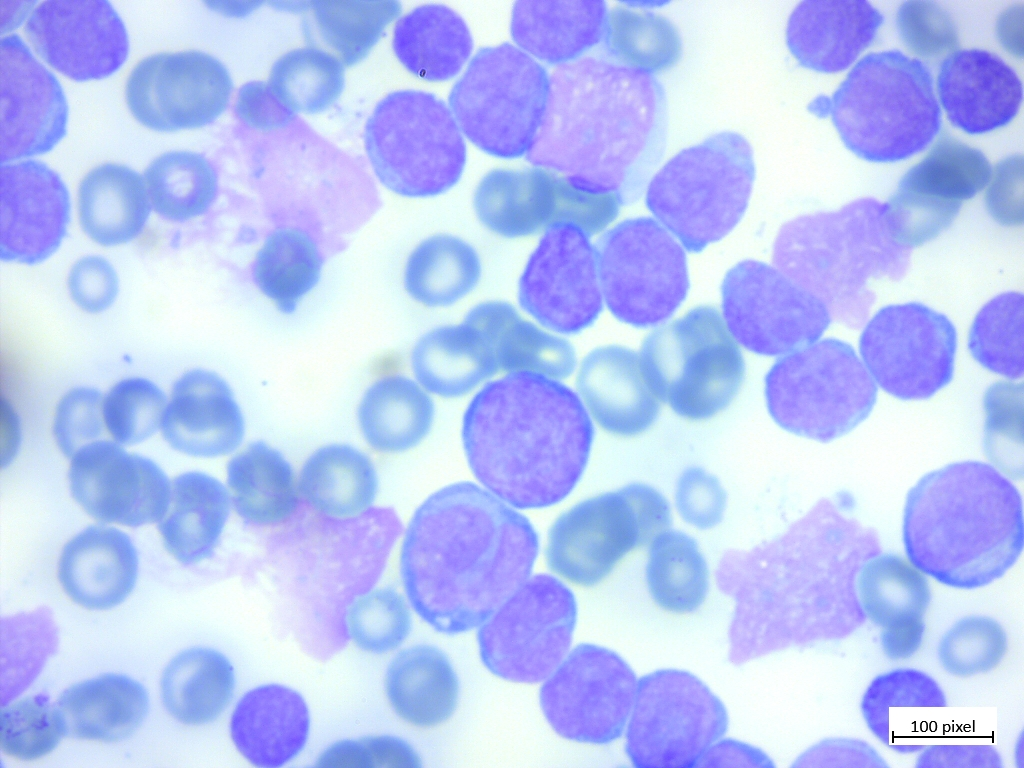

In [9]:
# Select a random image from the folder
random_image_path = random.choice(image_strings)
img = Image.open(random_image_path)

# Display metadata and show the image
print(f"Random image path: {random_image_path}")
print(f"Size of image: {img.height} x {img.width}")
print(f"Number of channels: {img.getbands()}")
img

## 2. Load data set in PyTorch format

In [10]:
# Write transformations to prepare images
data_transform = transforms.Compose([transforms.Resize(size=(128, 128)),
                                    transforms.ToTensor()])

Image information
-----------------------------------------------------------
Original image size: (768, 1024, 3)
Range[min:0, max: 255]
-----------------------------------------------------------
Transformed image size: torch.Size([128, 128, 3])
Range[min: 0.3137255012989044, max: 1.0]




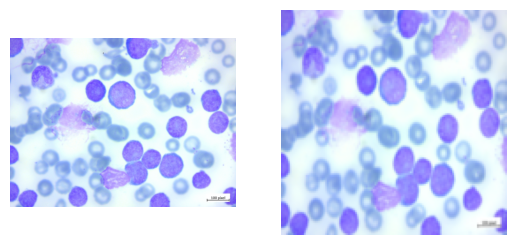

In [11]:
# Selecting a random image from the folder
random_image_path = random.choice(image_strings)
img = Image.open(random_image_path)
# Image transformation
transformed_image = data_transform(img).permute(1, 2, 0) # To display the image, the tensor with shape (C,H,W) is modified to (H,W,C)

## Image information
print("Image information")
print("-----------------------------------------------------------")
## ------ Original image ------
arr_img = np.asarray(img)
print(f"Original image size: {arr_img.shape}")
print(f"Range[min:{arr_img.min()}, max: {arr_img.max()}]")
print("-----------------------------------------------------------")
## ------ Transformed image ------
print(f"Transformed image size: {transformed_image.shape}")
print(f"Range[min: {transformed_image.min()}, max: {transformed_image.max()}]")
print("\n")

# Plot original image and transformation
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].axis("off")

ax[1].imshow(transformed_image)
ax[1].axis("off")
plt.show()

#### Load data set with Dataset class

In [12]:
class CustomDataset(Dataset):
    def __init__(self,img_path,transform=None):
        self.img_path = img_path
        self.data = glob.glob(glob.escape(self.img_path) + "*.jpg")
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_path = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image

In [13]:
train_dataset = CustomDataset('/content/Blood cell Cancer [ALL]/[Malignant] Pre-B/',transform=data_transform)
print(f"Tamaño del Dataset: {len(train_dataset)}")

Tamaño del Dataset: 955


In [14]:
# DataLoader is used to load the dataset for training
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_dataset,
                               batch_size = BATCH_SIZE,# Number of samples contained in each batch
                               shuffle = True)

In [15]:
print(f"Number of batches in the train loader: {len(train_dataloader)} batches of {BATCH_SIZE} images each one")

Number of batches in the train loader: 30 batches of 32 images each one


In [16]:
# Verify what is inside the DataLoader
train_batches = next(iter(train_dataloader))
print(train_batches.shape)

torch.Size([32, 3, 128, 128])


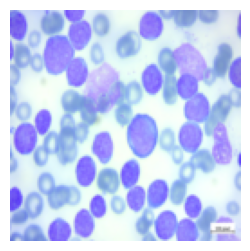

In [17]:
# Plot a random image of the batch
random_idx = random.randint(0, len(train_batches)-1)
img_batch = train_batches[random_idx]
fig = plt.figure(figsize=(3,3))
plt.imshow(img_batch.squeeze().permute(1, 2, 0))
plt.axis("off")
plt.show()

In [18]:
# CPU or GPU configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda



## 3. Define models

#### Discriminator
<br/>

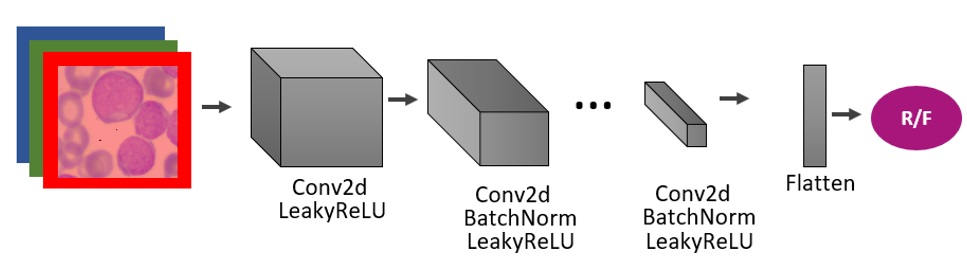

In [19]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self, channels_img, hidden_units):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=channels_img, out_channels=hidden_units, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [20]:
# Configure the model with input parameters
discriminator = Discriminator(channels_img=3, hidden_units=16)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=16384, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [21]:
# Test discriminator with dummy input
dummy_x = torch.rand([1,3,128,128]).to(device)
print(f"Discriminator input vector size: {dummy_x.size()}")

dummy_out = discriminator(dummy_x).detach()
print(f"Discriminator output: {dummy_out}")

Discriminator input vector size: torch.Size([1, 3, 128, 128])
Discriminator output: tensor([[0.6108]], device='cuda:0')


#### Generator

<br/>

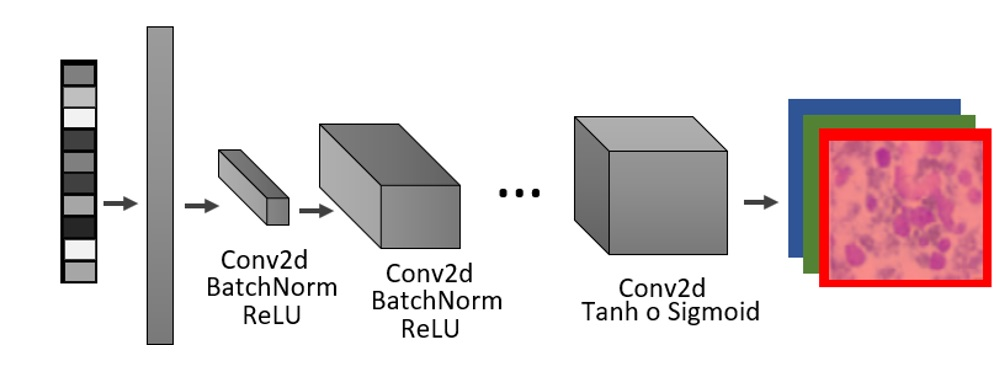

In [22]:
# Generator Model Class Definition
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_units):
        super().__init__()
        self.hidden_units = hidden_units
        self.block1 = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=32*32*hidden_units*4))
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_units*4, out_channels=hidden_units*2, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.BatchNorm2d(hidden_units*2),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=hidden_units*2, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=hidden_units, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.block1(x)
        # reshape from flatten to 7*7*hidden_units
        x = torch.reshape(x, (-1, self.hidden_units*4,32,32))
        x = self.block2(x)
        return x

In [23]:
LATENT_DIM = 256

In [24]:
# Configure the model with input parameters
generator = Generator(latent_dim=LATENT_DIM, hidden_units=16)
generator.to(device)

Generator(
  (block1): Sequential(
    (0): Linear(in_features=256, out_features=65536, bias=True)
  )
  (block2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
)

In [25]:
# Test generator with dummy input
dummy_x = torch.rand([1,LATENT_DIM]).to(device)
print(f"Generator input vector size: {dummy_x.size()}")

dummy_img = generator(dummy_x).cpu().detach()
print(f"Generator output size: {dummy_img.shape}")

Generator input vector size: torch.Size([1, 256])
Generator output size: torch.Size([1, 3, 128, 128])


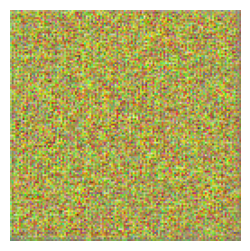

In [26]:
# Plot generated image
fig = plt.figure(figsize=(3,3))
plt.imshow(dummy_img.squeeze().permute(1, 2, 0))
plt.axis("off")
plt.show()

#### Optimization

In [27]:
# Define optimizer hyperparameters
lr = 0.0002
betas = (0.5, 0.999)

generator_opt = torch.optim.Adam(params=generator.parameters(), lr=lr, betas=betas)
discriminator_opt = torch.optim.Adam(params=discriminator.parameters(), lr=lr, betas=betas)


#### Discriminator cost function

In [28]:
def discriminator_loss(real_out, fake_out,smoothing_factor = 0.9):
    '''
    Input:
    - real_out. Real Image Predictions
    - fake_ out. Fake Image Predictions
    -smoothing_factor. Noise factor at the discriminator input
    '''
    real_loss = F.binary_cross_entropy(real_out, torch.ones_like(real_out)*smoothing_factor)
    fake_loss = F.binary_cross_entropy(fake_out, torch.zeros_like(fake_out))
    total_loss = (real_loss + fake_loss)/2
    return total_loss


#### Generator cost function

In [29]:
def generator_loss(fake_out):
    '''
    Input:
    - fake_ out. Fake Image Predictions
    '''
    gen_loss = F.binary_cross_entropy(fake_out, torch.ones_like(fake_out))
    return gen_loss


## 4. Training

In [30]:
def generate_noise_vectors(sample_size,latent_dim):
    '''
    Input:
    - sample_size. Sample sizes
    - latent_dim. Vector dimension
    '''
    noise_vector = torch.randn(sample_size,latent_dim)
    return noise_vector

In [31]:
# Generate vectors for test images
num_images_test = 25
torch.manual_seed(42)
noise_test = generate_noise_vectors(num_images_test,LATENT_DIM)
noise_test.shape

torch.Size([25, 256])

In [32]:
def show_grid(images, epoch, rows = int(math.sqrt(num_images_test))):
    num = images.size(0)
    fig = plt.figure(figsize= (5,5))

    for i in range(1, num+1):
        fig.add_subplot(rows, rows, i)
        plt.axis('off')
        plt.imshow(images[i-1].squeeze().permute(1, 2, 0))

    plt.savefig('./image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    return

In [33]:
EPOCHS = 200

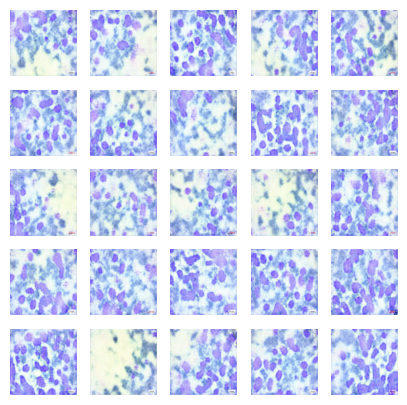

Epoch: 196
--------
Train Epoch: 196 [0/955 (0%)]	G-Loss: 3.628602 D-Loss: 0.187720
Epoch: 197
--------
Train Epoch: 197 [0/955 (0%)]	G-Loss: 2.711092 D-Loss: 0.243342
Epoch: 198
--------
Train Epoch: 198 [0/955 (0%)]	G-Loss: 3.500137 D-Loss: 0.266052
Epoch: 199
--------
Train Epoch: 199 [0/955 (0%)]	G-Loss: 4.278100 D-Loss: 0.308790


In [34]:
# training mode
generator.train()
discriminator.train()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------" )
    for batch, (real_images) in enumerate(train_dataloader):
        ## ---------------------- Train Discriminator ----------------------
        for i in range(0,2):
            # train the discriminator
            discriminator_opt.zero_grad()
            cur_batch_size = len(real_images)
            real_images = real_images.to(device)
            noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
            fake_images = generator(noise)
            # Training on real data
            real_preds = discriminator(real_images)
            # Training on fake data
            fake_preds = discriminator(fake_images.detach())
            disc_loss = discriminator_loss(real_preds, fake_preds,0.9)
            disc_loss.backward()
            # Optimizer step
            discriminator_opt.step()

        ## ---------------------- Train Generator ----------------------
        noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
        generated_images = generator(noise)
        # train the generator
        generator_opt.zero_grad()
        # Generación de imagenes
        fake_preds = discriminator(generated_images)
        gen_loss = generator_loss(fake_preds)
        gen_loss.backward()
        generator_opt.step()

        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tG-Loss: {:.6f} D-Loss: {:.6f}'.format(
                epoch, batch * len(real_images), len(train_dataloader.dataset),
                100. * batch / len(train_dataloader), gen_loss.item(), disc_loss.item()))


    #show the test images every 10 epochs
    if epoch%5 ==0:
        display.clear_output(wait=True)
        test_imgs = generator(noise_test.to(device)).detach()
        test_imgs = test_imgs.cpu()
        show_grid(test_imgs,epoch)

## 5. Generate new images

In [35]:
noise = generate_noise_vectors(15,LATENT_DIM).to(device)
print('Input: ',noise.shape)
with torch.inference_mode():
    fake_images = generator(noise)
print('Output: ',fake_images.shape)
fake_images = fake_images.cpu()



Input:  torch.Size([15, 256])
Output:  torch.Size([15, 3, 128, 128])


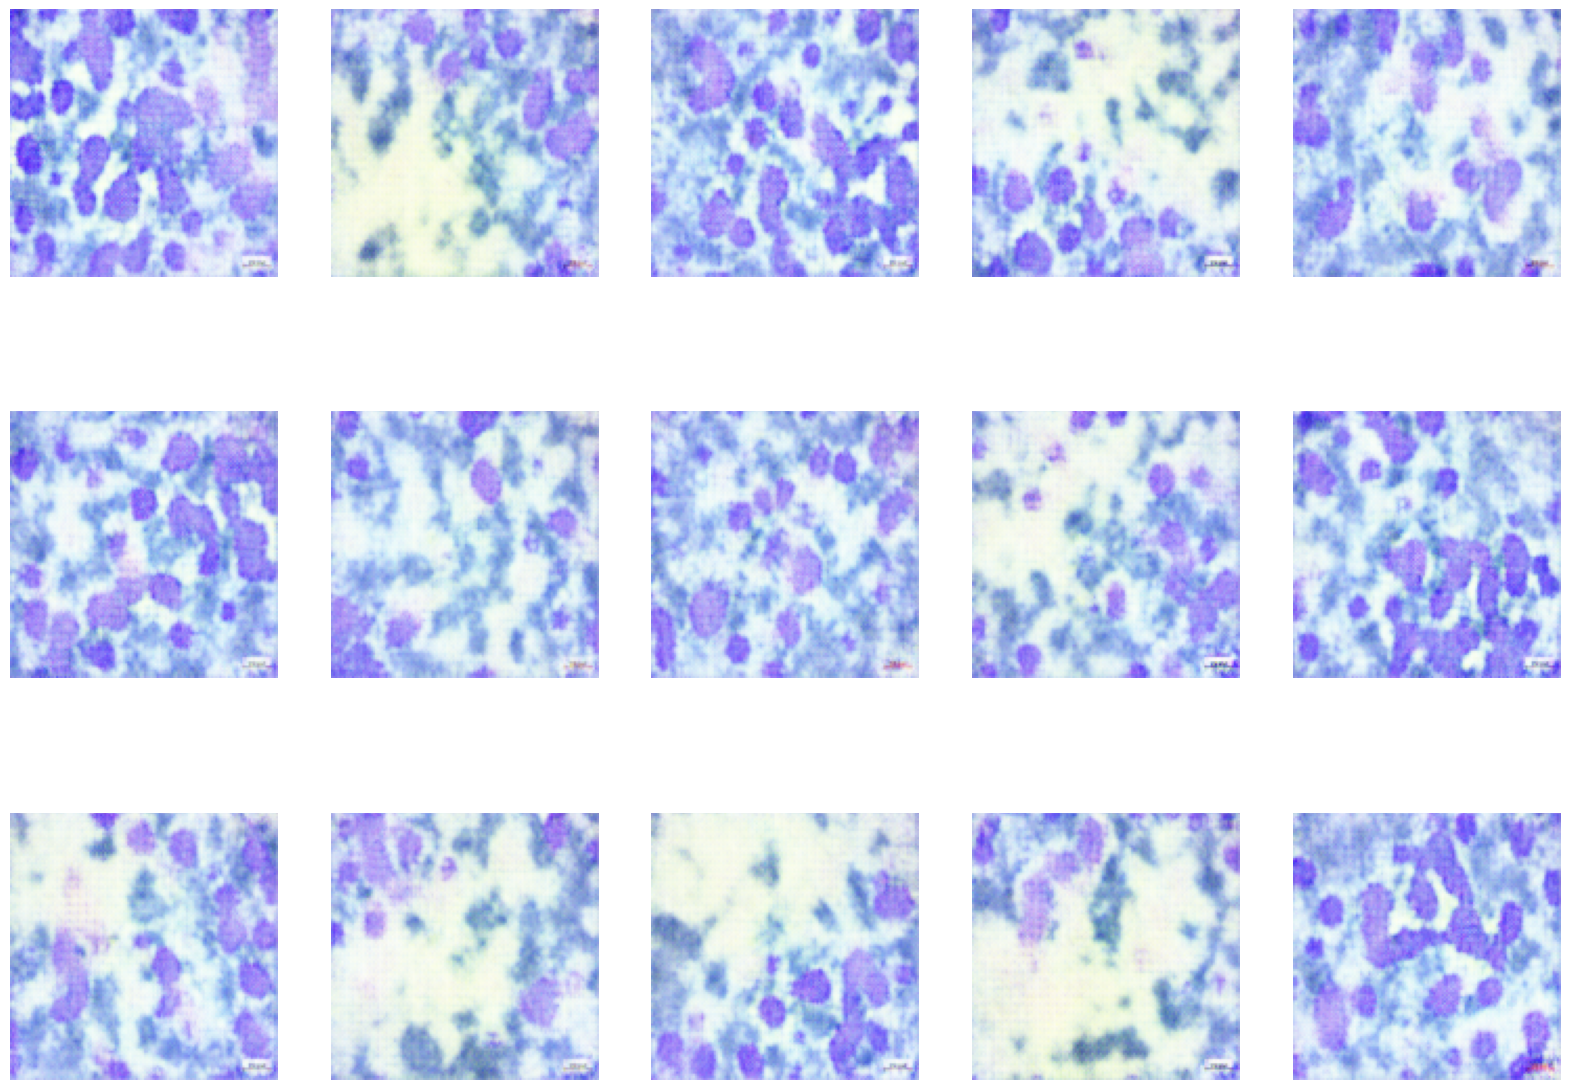

In [36]:
num = fake_images.size(0)
fig = plt.figure(figsize= (20,20))

for i in range(1, num+1):
    fig.add_subplot(4, 4+1, i)
    plt.axis('off')
    plt.imshow(fake_images[i-1].squeeze().permute(1, 2, 0))


plt.show()